In [392]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn import datasets
import sklearn
%matplotlib inline

torch.manual_seed(1)    # reproducible

In [393]:
def generate_data(N=80):
    r = np.linspace(0, 2,num=N)
    
    r1 = (2)*np.random.random_sample(N)
    r2 = (2)*np.random.random_sample(N)
    xTr1 = np.array([r1, np.power(r1,3)-2*np.square(r1)]).T
    xTr2 = np.array([r2, np.power(r2,3)-2*np.square(r2)-2.5+np.random.random_sample(N)]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

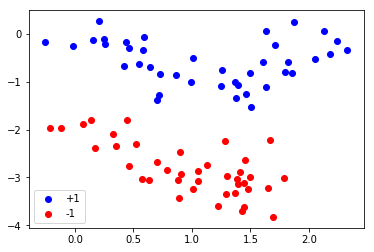

In [394]:
xTr,yTr,xTe,yTe=generate_data()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [395]:
def two_moons(N=10):
    x = sklearn.datasets.make_moons(n_samples=N, shuffle=False, noise=0.1, random_state=None)
    xTr = x[0]
    yTr = x[1]
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

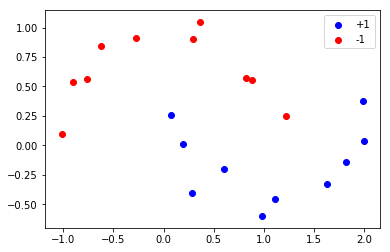

In [396]:
xTr,yTr,xTe,yTe=two_moons(40)
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [397]:
import densenet as dn

In [398]:
dn_model = dn.DenseNet3(20, 2, 4, reduction=0.5,
                     bottleneck=True, dropRate=0)

In [399]:
dn_model

DenseNet3 (
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): DenseBlock (
    (layer): Sequential (
      (0): BottleneckBlock (
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BottleneckBlock (
        (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): BottleneckBlock (
        (bn1): BatchNorm2d(16, ep

In [433]:
# torch can only train on Variable, so convert them to Variable
x = torch.from_numpy(xTr).float()
y = torch.from_numpy(yTr)
x = x.contiguous()
size = x.size()[0]
x = x.view(size,1,1,2)
x, y = Variable(x), Variable(y)

In [434]:
print('Number of model parameters: {}'.format(
            sum([p.data.nelement() for p in dn_model.parameters()])))

Number of model parameters: 30794


In [435]:
optimizer = torch.optim.SGD(dn_model.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

In [462]:
# plt.ion() 
for t in range(100):
    out = dn_model(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
#     print(out)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
#     print(loss.data)
#     if t % 10 == 0 or t in [3, 6]:
#         # plot and show learning process
#         plt.cla()
#         _, prediction = torch.max(F.softmax(out), 1)
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y.data.numpy()
#         print(loss.data)
#         plt.scatter(x.view(-1,2).data.numpy()[:, 0], x.view(-1,2).data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
#         accuracy = sum(pred_y == target_y)/x.size()[0]
#         plt.text(1.5, -1, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
#         plt.show()
#         plt.pause(0.1)

# plt.ioff()
loss.data[0]

ValueError: Expected 4D tensor as input, got 2D tensor instead.

In [530]:
class fc_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,n_hidden,dropRate):
        super(fc_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.n_hidden = n_hidden
        self.layer = self._make_layer(nb_layers, in_planes,n_hidden, dropRate,num_classes)
        self.out = nn.Linear(n_hidden,num_classes)
    def _make_layer(self,nb_layers,in_planes,n_hidden,dropRate,num_classes):
        layers = []
        for i in range(nb_layers):
            if i == 0:
                layers.append(nn.Linear(in_planes, n_hidden))
                layers.append(nn.ReLU(inplace=True))
#                 layers.append(nn.Linear(n_hidden, n_hidden))
#                 layers.append(nn.ReLU(inplace=True))
            else:
                layers.append(nn.Linear(n_hidden, n_hidden))
                layers.append(nn.ReLU(inplace=True))
#         layers.append(nn.Dropout(p=self.dropRate))
#         layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
#         x = F.relu(x)
        return self.out(x)

In [576]:

model_2 = fc_model(2,4,2,15,0)
print(model_2)
print('Number of model parameters: {}'.format(
            sum([p.data.nelement() for p in model_2.parameters()])))

fc_model (
  (layer): Sequential (
    (0): Linear (2 -> 15)
    (1): ReLU (inplace)
    (2): Linear (15 -> 15)
    (3): ReLU (inplace)
    (4): Linear (15 -> 15)
    (5): ReLU (inplace)
    (6): Linear (15 -> 15)
    (7): ReLU (inplace)
  )
  (out): Linear (15 -> 2)
)
Number of model parameters: 797


In [577]:
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
# plt.ion() 
for t in range(1500):
    out = model_2(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
#     print(out)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
# #     print(loss.data)
#     if t % 10 == 0 or t in [3, 6]:
#         print(loss.data[0])
#         # plot and show learning process
#         plt.cla()
#         _, prediction = torch.max(F.softmax(out), 1)
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y.data.numpy()
#         plt.scatter(x.view(-1,2).data.numpy()[:, 0], x.view(-1,2).data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
#         accuracy = sum(pred_y == target_y)/x.size()[0]
#         print(loss.data.numpy())
#         plt.text(1.5, -1, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
# #         plt.text(1.5, -1, 'Loss=%.2f' % loss.x, fontdict={'size': 20, 'color':  'red'})
#         plt.show()
#         plt.pause(0.1)

# plt.ioff()

print("FeedForward connection training loss",loss.data[0])

FeedForward connection training loss 0.06752514094114304


In [587]:
class DenseLayer(nn.Module):
    def __init__(self,in_planes,n_hidden,dropRate):
        super(DenseLayer,self).__init__()
        self.Denselayer = nn.Linear(in_planes,n_hidden)
    
    def forward(self,x):
        out = self.Denselayer(x)
        out = F.relu(out)
        return torch.cat([x, out], 1)

class dense_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,dropRate,growth_rate):
        super(dense_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.in_planes = in_planes
        
        self.layer = self._make_layer(nb_layers,in_planes,dropRate,num_classes,growth_rate)
        self.out = nn.Linear(in_planes+nb_layers*growth_rate,num_classes)
    
    def _make_layer(self,nb_layers,in_planes,dropRate,num_classes,growth_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(DenseLayer(in_planes+i*growth_rate, growth_rate,dropRate))
#             layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
        F.relu(x)
        return self.out(x)

In [588]:
dense_model = dense_model(num_classes=2,nb_layers=4,in_planes= 2,dropRate = 0,growth_rate=10)

In [589]:
dense_model

dense_model (
  (layer): Sequential (
    (0): DenseLayer (
      (Denselayer): Linear (2 -> 10)
    )
    (1): DenseLayer (
      (Denselayer): Linear (12 -> 10)
    )
    (2): DenseLayer (
      (Denselayer): Linear (22 -> 10)
    )
    (3): DenseLayer (
      (Denselayer): Linear (32 -> 10)
    )
  )
  (out): Linear (42 -> 2)
)

In [590]:
optimizer = torch.optim.SGD(dense_model.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
# plt.ion() 
for t in range(2000):
    out = dense_model(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
#     print(out)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
#     print(loss.data)
#     if t % 10 == 0 or t in [3, 6]:
#         # plot and show learning process
#         plt.cla()
#         _, prediction = torch.max(F.softmax(out), 1)
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y.data.numpy()
#         plt.scatter(x.view(-1,2).data.numpy()[:, 0], x.view(-1,2).data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
#         accuracy = sum(pred_y == target_y)/x.size()[0]
#         print(loss.data.numpy())
#         plt.text(1.5, -1, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color':  'red'})
# #         plt.text(1.5, -1, 'Loss=%.2f' % loss.x, fontdict={'size': 20, 'color':  'red'})
#         plt.show()
#         plt.pause(0.1)

# # plt.ioff()

print("Dense Connection training loss",loss.data[0])

Dense Connection training loss 0.07693500816822052


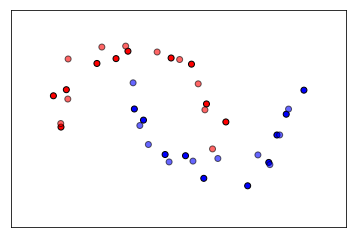

In [591]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

h = 0.02
x_min, x_max = xTr[:, 0].min() - .5, xTr[:, 0].max() + .5
y_min, y_max = xTr[:, 1].min() - .5, xTr[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 1, 1)


# Plot the training points
ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())



grid = np.c_[xx.ravel(), yy.ravel()]
# torch can only train on Variable, so convert them to Variable
grid = torch.from_numpy(grid).float()
# x = x.contiguous()
size = grid.shape[0]
grid = Variable(grid)

DenseNet Conv
(26004,)
1
Linear
(26004,)
2
Dense Model
(26004,)
3


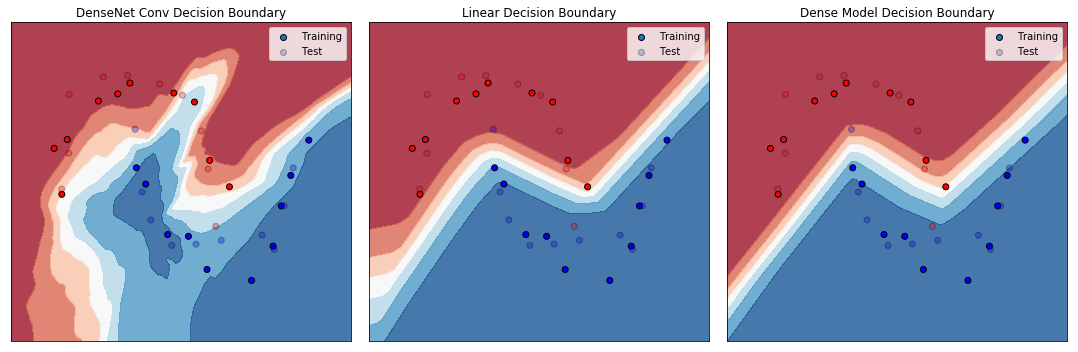

In [592]:
names = ["DenseNet Conv","Linear","Dense Model"]
models = [dn_model,model_2,dense_model]
i = 1

figure = plt.figure(figsize=(20, 5))
for name,model in zip(names,models):

    if name == "Linear" or name == "Dense Model":
        grid = grid.view(size,2)
    else:
        grid = grid.view(size,1,1,2)
         
    print(name)
    
    ax = plt.subplot(1, len(models) + 1, i)
#     print(model)
    Z = F.softmax(model(grid))
#     print(Z)
#     Z = Z[:,1].data.numpy()
    Z = Z.data.numpy().reshape(-1,2)[:,1]
    print(Z.shape)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
               edgecolors='k',label="Training")
    # and testing points
    ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright,
               edgecolors='k', alpha=0.3,label="Test")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(name+" Decision Boundary")
    plt.tight_layout()
    plt.legend()
    print(i)
    i+=1
plt.show()